En este archivo vamos a entrenar una red neuronal para predecir el resultado de los partidos de la Champions bsándonos en datos de los último 7 años.

Para empezar primero cargamos las librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import regularizers
import matplotlib.pyplot as plt
import random

Ahora vamos a empezar el entrenamiento para predecir resultados, pero antes de ello vamos a transformar las columnas string de equipos en numéricas para poder evaluarlas y analizarlas durante el procesamiento de la red neuronal.

In [2]:
# Cargar los datos del ranking UEFA
uefa_ranking = pd.read_csv("data/UEFA_Ranking.csv")

#Saca el número de valores unicos de la columna Club de ranking UEFA
uefa_ranking['Club'].nunique()

570

In [3]:
# Crear un diccionario para mapear nombres de equipos a números únicos
team_mapping = {team: idx + 1 for idx, team in enumerate(uefa_ranking['Club'])}

# Cargar los datos de los partidos de la Champions League 2017
champions_data = pd.read_csv("data/champions-league-2017.csv")

# Crear una columna Home Team Name que sea una copia de la columna Home Team
champions_data['Home Team Name'] = champions_data['Home Team']

# Crear una columna Away Team Name que sea una copia de la columna Away Team
champions_data['Away Team Name'] = champions_data['Away Team']

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions_data['Home Team'] = champions_data['Home Team'].map(team_mapping)
champions_data['Away Team'] = champions_data['Away Team'].map(team_mapping)
champions_data['Winner'] = champions_data['Winner'].map(team_mapping)

Vamos a comprobar que todos los datos están bien.

In [4]:
# Ver las primeras filas de los datos
print(champions_data.head())

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         20         62  1 - 2      62   
1             2            1         11         26  3 - 0      11   
2            13            1          2         53  3 - 0       2   
3            14            1         50          8  0 - 5       8   
4            25            1          9         66  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                2            3            Benfica   
1                3                0            3  Manchester United   
2                3                0            3     Bayern München   
3                0                5            5             Celtic   
4                6                0            6            Chelsea   

        Away Team Name  
0          CSKA Moscow  
1             FC Basel  
2           Anderlecht  
3  Paris Saint-Germain  
4           Qarabag FK  


In [5]:
# analizar los datos
print(champions_data.describe())

       Match Number   Home Team   Away Team      Winner  Home Team Goals  \
count    125.000000  125.000000  125.000000  125.000000       125.000000   
mean      63.000000   25.432000   25.464000   17.312000         1.784000   
std       36.228442   28.471076   28.445631   22.202302         1.532361   
min        1.000000    1.000000    1.000000    1.000000         0.000000   
25%       32.000000    6.000000    6.000000    4.000000         1.000000   
50%       63.000000   14.000000   14.000000   10.000000         1.000000   
75%       94.000000   36.000000   36.000000   23.000000         3.000000   
max      125.000000  120.000000  120.000000  120.000000         7.000000   

       Away Team Goals  Match Goals  
count       125.000000   125.000000  
mean          1.424000     3.208000  
std           1.398525     1.622901  
min           0.000000     0.000000  
25%           0.000000     2.000000  
50%           1.000000     3.000000  
75%           2.000000     4.000000  
max        

In [6]:
# ver los datos nulos
print(champions_data.isnull().sum())

Match Number       0
Round Number       0
Home Team          0
Away Team          0
Result             0
Winner             0
Home Team Goals    0
Away Team Goals    0
Match Goals        0
Home Team Name     0
Away Team Name     0
dtype: int64


Como podemos ver está todo bien. Para más información con respecto al CSV que estamos tratando dirigirse a graficas.ipynb

Ahora vamos a comenzar el proceso de entrenamiento de la red neuronal

In [7]:
'''
# Preprocesamiento de datos
X = champions_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals']].values
y = champions_data['Winner'].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Goals', 'Away Team Goals']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Definir modelo de red neuronal con más complejidad
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# Compilar modelo con hiperparámetros ajustados
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
'''

'\n# Preprocesamiento de datos\nX = champions_data[[\'Home Team\', \'Away Team\', \'Home Team Goals\', \'Away Team Goals\']].values\ny = champions_data[\'Winner\'].values\n\n# Separar características categóricas y numéricas\ncategorical_features = [\'Home Team\', \'Away Team\']\nnumeric_features = [\'Home Team Goals\', \'Away Team Goals\']\n\nX_categorical = champions_data[categorical_features].values\nX_numeric = champions_data[numeric_features].values\n\n# Codificar características categóricas\nX_categorical_encoded = np.zeros_like(X_categorical)\nfor i in range(X_categorical.shape[1]):\n    label_encoder = LabelEncoder()\n    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])\n\n# Normalizar características numéricas\nscaler = StandardScaler()\nX_numeric_scaled = scaler.fit_transform(X_numeric)\n\n# Combinar características categóricas y numéricas\nX_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)\n\n# Codificar etiquetas\nlab

In [8]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

# Crear una columna para representar el resultado del partido
champions_data['Home is Winner'] = champions_data['Home Team Goals'] - champions_data['Away Team Goals']
champions_data['Home is Winner'] = champions_data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

# Dividir los datos en características (X) y variable objetivo (y)
X = champions_data[['Home Team', 'Away Team']]
y = champions_data['Home is Winner']
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
'''
# Preprocesamiento de datos
X = champions_data[['Home Team', 'Away Team']].values
y = champions_data['Winner'].values

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)
'''

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir modelo de red neuronal
model = Sequential()
model.add(Dense(128, input_dim=2, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=90, batch_size=42, validation_data=(X_test, y_test))

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/90


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5530 - loss: 0.7402 - val_accuracy: 0.6800 - val_loss: 0.9185
Epoch 2/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7480 - loss: 0.5575 - val_accuracy: 0.6800 - val_loss: 1.0410
Epoch 3/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7460 - loss: 0.6029 - val_accuracy: 0.6800 - val_loss: 0.9577
Epoch 4/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7301 - loss: 0.5905 - val_accuracy: 0.6400 - val_loss: 0.8672
Epoch 5/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6921 - loss: 0.5852 - val_accuracy: 0.6400 - val_loss: 0.7237
Epoch 6/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6931 - loss: 0.5825 - val_accuracy: 0.6400 - val_loss: 0.6449
Epoch 7/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6015 - loss: 0.6385 - val_accuracy: 0.6000 - val_loss: 0.7196
Epoch 8/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6604 - loss: 0.6039 - val_accuracy: 0.6800 - val_loss: 0.7009
Epoch 9/90


Vemos que el entrenamiento inicial ha ido sin problemas. Vamos a probar a ver que predicciones realizaría nuestra red neuronal en base a los partidos de la Champions utilizada para obtener una medida de precisión real. Para ello primero vamos a medir la precisión de una predicción en general.

In [9]:
# Hacer predicciones en los datos de prueba
predictions = model.predict(X_test)

# Redondear las predicciones a etiquetas binarias (0 o 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calcular la precisión
accuracy = np.mean(predicted_labels.flatten() == y_test)
print("Accuracy on test data:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Accuracy on test data: 0.64


Como puede verse con este resultado y la medición general anterior, la precisión del modelo es casi inexistente debido al alto error, por lo que vamos a seguir entrenándolo. Primero vamos a aplicar ingeniería de características para darle al modelo más variables sobre las que extraer información. Algunas de estas nos serán útiles a la hora de predecir el resultado de cada partido:

In [10]:
# Calcular la diferencia de goles entre los equipos
champions_data['Goal Difference'] = champions_data['Home Team Goals'] - champions_data['Away Team Goals']

# Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
champions_data['Home Goals Ratio'] = champions_data['Home Team Goals'] / champions_data['Match Goals']
champions_data['Away Goals Ratio'] = champions_data['Away Team Goals'] / champions_data['Match Goals']

# Fusionar los datos de champions_data con la información de uefa_ranking basado en el nombre del equipo local
champions_data = champions_data.merge(uefa_ranking[['Club', '17/18']], left_on='Home Team Name', right_on='Club', how='left')
champions_data.rename(columns={'17/18': 'Home Team Evaluation'}, inplace=True)
champions_data.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data = champions_data.merge(uefa_ranking[['Club', '17/18']], left_on='Away Team Name', right_on='Club', how='left')
champions_data.rename(columns={'17/18': 'Away Team Evaluation'}, inplace=True)
champions_data.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data['Penalties'] = champions_data['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data['Penalties Winner'] = champions_data.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13
round_number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    'Round of 16 - Game 1': 7,
    'Round of 16 - Game 2': 8,
    'Qtr Finals - Game 1': 9,
    'Qtr Finals - Game 2': 10,
    'Semi Finals - Game 1': 11,
    'Semi Finals - Game 2': 12,
    'Final': 13
}

champions_data['Round Number'] = champions_data['Round Number'].map(round_number_mapping).fillna(champions_data['Round Number'])

# Añadir una columna win Home Team Win Streak que indica cuántos partidos consecutivos ha ganado el equipo local
# Inicializar un diccionario para el seguimiento de las rachas de victorias
team_win_streak = {'Home Team': {}, 'Away Team': {}}

# Iterar a través de las filas del DataFrame
for index, row in champions_data.iterrows():
    home_team = row['Home Team']
    away_team = row['Away Team']
    winner = row['Winner']
    
    # Inicializar las rachas de victorias si no existen en el diccionario
    for team in [home_team, away_team]:
        if team not in team_win_streak['Home Team']:
            team_win_streak['Home Team'][team] = 0
        if team not in team_win_streak['Away Team']:
            team_win_streak['Away Team'][team] = 0
    
    # Actualizar las rachas de victorias para el equipo ganador
    if winner == home_team:
        team_win_streak['Home Team'][home_team] += 1
        team_win_streak['Away Team'][away_team] = 0
    elif winner == away_team:
        team_win_streak['Home Team'][home_team] = 0
        team_win_streak['Away Team'][away_team] += 1
    else:
        team_win_streak['Home Team'][home_team] = 0
        team_win_streak['Away Team'][away_team] = 0
    
    # Añadir las rachas de victorias al DataFrame
    champions_data.at[index, 'Home Team Win Streak'] = team_win_streak['Home Team'][home_team]
    champions_data.at[index, 'Away Team Win Streak'] = team_win_streak['Away Team'][away_team]

# Ver las primeras filas de los datos
print(champions_data.head())


   Match Number  Round Number  Home Team  Away Team Result  Winner  \
0             1             1         15         27  1 - 2      62   
1             2             1         10         19  3 - 0      11   
2            13             1          1         26  3 - 0       2   
3            14             1         25          7  0 - 5       8   
4            25             1          8         28  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  ...  \
0                1                2            3            Benfica  ...   
1                3                0            3  Manchester United  ...   
2                3                0            3     Bayern München  ...   
3                0                5            5             Celtic  ...   
4                6                0            6            Chelsea  ...   

  Home is Winner  Goal Difference  Home Goals Ratio  Away Goals Ratio  \
0              0               -1          0.3333

In [11]:
# Ver las estadísticas de los datos
print(champions_data.describe())

       Match Number  Round Number   Home Team   Away Team      Winner  \
count    125.000000    125.000000  125.000000  125.000000  125.000000   
mean      63.000000      4.728000   13.536000   13.568000   17.312000   
std       36.228442      2.823793    9.400192    9.360466   22.202302   
min        1.000000      1.000000    0.000000    0.000000    1.000000   
25%       32.000000      2.000000    5.000000    5.000000    4.000000   
50%       63.000000      4.000000   13.000000   13.000000   10.000000   
75%       94.000000      6.000000   21.000000   21.000000   23.000000   
max      125.000000     13.000000   31.000000   31.000000  120.000000   

       Home Team Goals  Away Team Goals  Match Goals  Home is Winner  \
count       125.000000       125.000000   125.000000       125.00000   
mean          1.784000         1.424000     3.208000         0.44800   
std           1.532361         1.398525     1.622901         0.49929   
min           0.000000         0.000000     0.000000  

In [12]:
# Ver los datos nulos
print(champions_data.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio          7
Home Team Evaluation      0
Away Team Evaluation      0
Penalties                 0
Penalties Winner        118
Home Team Win Streak      0
Away Team Win Streak      0
dtype: int64


In [13]:
# Ver las columnas Home Goals Ratio y Away Goals Ratio donde hay datos nulos
print(champions_data[['Home Goals Ratio', 'Away Goals Ratio']], '\n')
print(champions_data[champions_data['Home Goals Ratio'].isnull()])

     Home Goals Ratio  Away Goals Ratio
0            0.333333          0.666667
1            1.000000          0.000000
2            1.000000          0.000000
3            0.000000          1.000000
4            1.000000          0.000000
..                ...               ...
120          0.714286          0.285714
121          0.333333          0.666667
122          0.500000          0.500000
123          0.666667          0.333333
124          0.750000          0.250000

[125 rows x 2 columns] 

     Match Number  Round Number  Home Team  Away Team Result  Winner  \
5              26             1         13          6  0 - 0       7   
40             29             3         28          6  0 - 0       7   
55             44             4         23          2  0 - 0       3   
78             45             5          5          2  0 - 0       3   
102           103             7          9         10  0 - 0      11   
104           105             8          4         11  0 - 0  

Vemos aquí el problema de partidos donde no hay goles. De momento vamos a dejarlo como está para darle más realismo al entrenamiento de la red neuronal:

In [14]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']].values
y = champions_data['Home is Winner']'''

# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation']].values
y = champions_data['Home is Winner']

'''
# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)'''

print("Número de muestras en X:", X.shape[0])
print("Número de muestras en y:", y.shape[0])

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)


Número de muestras en X: 125
Número de muestras en y: 125


Ahora vamos a ampliar el alcance de nuestra red neuronal:

In [15]:
# Definir modelo de red neuronal con más complejidad
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo con hiperparámetros ajustados
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.5583 - loss: 0.7738 - val_accuracy: 0.6000 - val_loss: 0.7581
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4000 - loss: 0.8281 - val_accuracy: 0.7500 - val_loss: 0.7478
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5583 - loss: 0.7591 - val_accuracy: 0.8500 - val_loss: 0.7376
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5917 - loss: 0.7590 - val_accuracy: 0.8500 - val_loss: 0.7282
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5000 - loss: 0.7662 - val_accuracy: 0.8500 - val_loss: 0.7192
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6750 - loss: 0.7294 - val_accuracy: 0.8500 - val_loss: 0.7107
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6583 - loss: 0.7230 - val_accuracy: 0.8500 - val_loss: 0.7026
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5917 - loss: 0.7549 - val_accuracy: 0.8000 - val_loss: 0.6948
Epo

La precisión ahora está un poco mejor ya que el error es más bajo, pero vamos a ver si podemos seguir mejorando. Para ello, vamos a ir probando diferentes parámetros y configuraciones para ajustar la red neuronal:

In [16]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Win Streak', 'Away Team Win Streak']]
y = champions_data['Home is Winner']

'''

# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']].values
y = champions_data['Winner'].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)
print("Número de clases:", num_classes)
y = to_categorical(y, num_classes=num_classes)

'''

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

ajustes = []
capas = ["softmax", "relu", "sigmoid", "tanh", "linear"]
optimizador = ["SGD", "RMSprop", "Adam", "AdamW", "Adadelta",
               "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftrl", "Lion"]

num_capas = [1, 2, 3, 4, 5]
num_neuronas = [16, 32, 64, 128, 256, 512, 1024]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

target_accuracy = 0.7
target_loss = 0.3

for _ in range(50):
    # Configuración aleatoria
    configuracion_aleatoria = {
        "capa_activacion": random.choice(capas),
        "optimizador": random.choice(optimizador),
        "num_capas": random.choice(num_capas),
        "num_neuronas": random.choice(num_neuronas),
        "learning_rate": random.choice(learning_rate)
    }

    # Crear el modelo con la configuración aleatoria
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], input_dim=7, activation=configuracion_aleatoria["capa_activacion"]))
    for _ in range(configuracion_aleatoria["num_capas"] - 1):
        model.add(tf.keras.layers.Dense(
            configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))

    # Última capa ajustada para el problema de clasificación multiclase
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con el optimizador y learning rate aleatorio
    optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
        learning_rate=configuracion_aleatoria["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=64)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)


    # Verificar si se alcanzaron las condiciones de término
    if accuracy >= target_accuracy and 0 <= loss <= target_loss:
        break

    # Si no se alcanzaron las condiciones de término, se guarda la configuración y se ordena por precisión en orden ascendente y evitando duplicados
    ajustes.append((configuracion_aleatoria, accuracy, loss))
    print(ajustes)

    # Guardar en un archivo txt
    with open('ajustes.txt', 'w') as f:
        for item in ajustes:
            f.write("%s\n" % str(item))

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2801 - loss: 2.1954
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2829 - loss: 1.8171 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2881 - loss: 1.5264 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3319 - loss: 1.1662 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3135 - loss: 0.9123 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4781 - loss: 0.8042 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5627 - loss: 0.6745 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7404 - loss: 0.5922 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7171 - loss: 0.5770 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6764 - loss: 0.5945 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7456 - loss: 0.5375 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7481 - loss: 0.5159 
Ep

Parece que aumentar la precisión va a ser imposible a menos que añadamos nuevos datos. Vamos pues a continuar añadiéndo datos de entrenamiento. Para ello vamos a prepararlos primero:

In [17]:
champions_data2 = pd.read_csv("data/champions-league-2018.csv")
champions_data3 = pd.read_csv("data/champions-league-2019.csv")
champions_data4 = pd.read_csv("data/champions-league-2020.csv")
champions_data5 = pd.read_csv("data/champions-league-2021.csv")
champions_data6 = pd.read_csv("data/champions-league-2022.csv")

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions = [champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]
years = ['18/19', '19/20', '20/21', '21/22', '22/23']
for data, year in zip(champions, years):

    # Crear una columna Home Team Name que sea una copia de la columna Home Team
    data['Home Team Name'] = data['Home Team']
    # Crear una columna Away Team Name que sea una copia de la columna Away Team
    data['Away Team Name'] = data['Away Team']
    
    data['Home Team'] = data['Home Team'].map(team_mapping)
    data['Away Team'] = data['Away Team'].map(team_mapping)
    data['Winner'] = data['Winner'].map(team_mapping)

    # Crear una columna para representar el resultado del partido
    data['Home is Winner'] = data['Home Team Goals'] - data['Away Team Goals']
    data['Home is Winner'] = data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Fusionar los datos de data con la información de uefa_ranking basado en el nombre del equipo local
    data = data.merge(uefa_ranking[['Club', year]], left_on='Home Team Name', right_on='Club', how='left')
    data.rename(columns={year: 'Home Team Evaluation'}, inplace=True)
    data.drop(columns=['Club'], inplace=True)

    # Fusionar los datos de data con la información de uefa_ranking basado en el nombre del equipo visitante
    data = data.merge(uefa_ranking[['Club', year]], left_on='Away Team Name', right_on='Club', how='left')
    data.rename(columns={year: 'Away Team Evaluation'}, inplace=True)
    data.drop(columns=['Club'], inplace=True)

    # Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
    data['Penalties'] = data['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
    data['Penalties Winner'] = data.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

    #Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
    # Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13
    round_number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    'Round of 16 - Game 1': 7,
    'Round of 16 - Game 2': 8,
    'Qtr Finals - Game 1': 9,
    'Qtr Finals - Game 2': 10,
    'Semi Finals - Game 1': 11,
    'Semi Finals - Game 2': 12,
    'Final': 13
}

    data['Round Number'] = data['Round Number'].map(round_number_mapping).fillna(data['Round Number'])

    # Añadir una columna win Home Team Win Streak que indica cuántos partidos consecutivos ha ganado el equipo local
    # Inicializar un diccionario para el seguimiento de las rachas de victorias
    team_win_streak = {'Home Team': {}, 'Away Team': {}}

    # Iterar a través de las filas del DataFrame
    for index, row in data.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        winner = row['Winner']
        
        # Inicializar las rachas de victorias si no existen en el diccionario
        for team in [home_team, away_team]:
            if team not in team_win_streak['Home Team']:
                team_win_streak['Home Team'][team] = 0
            if team not in team_win_streak['Away Team']:
                team_win_streak['Away Team'][team] = 0
        
        # Actualizar las rachas de victorias para el equipo ganador
        if winner == home_team:
            team_win_streak['Home Team'][home_team] += 1
            team_win_streak['Away Team'][away_team] = 0
        elif winner == away_team:
            team_win_streak['Home Team'][home_team] = 0
            team_win_streak['Away Team'][away_team] += 1
        else:
            team_win_streak['Home Team'][home_team] = 0
            team_win_streak['Away Team'][away_team] = 0
        
        # Añadir las rachas de victorias al DataFrame
        data.at[index, 'Home Team Win Streak'] = team_win_streak['Home Team'][home_team]
        data.at[index, 'Away Team Win Streak'] = team_win_streak['Away Team'][away_team]


In [18]:
# Ver los datos nulos de cada conjunto de datos
for i, data in enumerate(champions):
    print(f"Data {i + 2} null values:\n{data.isnull().sum()}\n")

Data 2 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    7
Away Goals Ratio    7
dtype: int64

Data 3 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    4
Away Goals Ratio    4
dtype: int64

Data 4 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Wi

Vemos que el csv 2 y 3 tienen datos nulos en partidos. Vamos a visualizarlos:

In [19]:
#Ver las filas Home Team, Away Team y Winner donde hay datos nulos en champions_data2
# Seleccionar las filas donde hay valores nulos en las columnas específicas
null_data = champions_data2[champions_data2[['Home Team', 'Away Team', 'Winner']].isnull().any(axis=1)]

# Mostrar las filas seleccionadas
print(null_data[['Home Team', 'Away Team', 'Winner']])

Empty DataFrame
Columns: [Home Team, Away Team, Winner]
Index: []


Las filas de Home Team donde no se ha podido dar un número al equipo de champions_data2 son la 4, 49 y 86. De Away Team la 24, 44 y 77 y de Winner la 49 que como ya ha salido se descarta. Para solucionar esto vamos a introducir en UEFA_Ranking.csv esos equipos al final y actualizar el mapeo. Para ello buscamos en data/champions-league-2018.csv esas filas, extraemos el nombre del equipo de la columna correspondiente y lo añadimos a UEFA_Ranking con todos los campos 0 excepto el de Position que tendrá el mismo número + 1 que el de la fila anterior última. Después volvemos a mapear:

In [20]:
#Ver la fila 4, 24, 44, 49, 77, 86 de champions-league-2018.csv
league_2018 = pd.read_csv("data/champions-league-2018.csv")
print(league_2018.iloc[[4, 24, 44, 49, 77, 86]])

    Match Number Round Number            Home Team            Away Team  \
4              5            1        Crvena zvezda               Napoli   
24            25            2  Paris Saint-Germain        Crvena zvezda   
44            45            3            Liverpool        Crvena zvezda   
49            50            4        Crvena zvezda            Liverpool   
77            78            5               Napoli        Crvena zvezda   
86            87            6        Crvena zvezda  Paris Saint-Germain   

   Result               Winner  Home Team Goals  Away Team Goals  Match Goals  
4   0 - 0               Napoli                0                0            0  
24  6 - 1  Paris Saint-Germain                6                1            7  
44  4 - 0            Liverpool                4                0            4  
49  2 - 0        Crvena zvezda                2                0            2  
77  3 - 1               Napoli                3                1          

El problema es el equipo Crvena zvezda. Vamos a añadirlo al mapeo una única vez:

In [21]:
# Agregar una fila para el equipo "Crvena zvezda" al archivo UEFA_Ranking.csv
new_row = {'Club': 'Crvena zvezda'}

if 'Crvena zvezda' not in uefa_ranking['Club'].values:
    uefa_ranking = pd.concat([uefa_ranking, pd.DataFrame([new_row])], ignore_index=True)

    # Guardar el DataFrame actualizado en un nuevo archivo CSV
    uefa_ranking.to_csv("data/UEFA_Ranking.csv", index=False)

In [22]:
# Actualizar el mapeo de nombres de equipos a números únicos
team_mapping = {team: idx + 1 for idx, team in enumerate(uefa_ranking['Club'])}

champions_data2 = pd.read_csv("data/champions-league-2018.csv")
champions_data3 = pd.read_csv("data/champions-league-2019.csv")
champions_data4 = pd.read_csv("data/champions-league-2020.csv")
champions_data5 = pd.read_csv("data/champions-league-2021.csv")
champions_data6 = pd.read_csv("data/champions-league-2022.csv")

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions = [champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]
years = ['18/19', '19/20', '20/21', '21/22', '22/23']
for data, year in zip(champions, years):

    # Crear una columna Home Team Name que sea una copia de la columna Home Team
    data['Home Team Name'] = data['Home Team']
    # Crear una columna Away Team Name que sea una copia de la columna Away Team
    data['Away Team Name'] = data['Away Team']
    
    data['Home Team'] = data['Home Team'].map(team_mapping)
    data['Away Team'] = data['Away Team'].map(team_mapping)
    data['Winner'] = data['Winner'].map(team_mapping)

    # Crear una columna para representar el resultado del partido
    data['Home is Winner'] = data['Home Team Goals'] - data['Away Team Goals']
    data['Home is Winner'] = data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Fusionar los datos de data con la información de uefa_ranking basado en el nombre del equipo local
    data = data.merge(uefa_ranking[['Club', year]], left_on='Home Team Name', right_on='Club', how='left')
    data.rename(columns={year: 'Home Team Evaluation'}, inplace=True)
    data.drop(columns=['Club'], inplace=True)

    # Fusionar los datos de data con la información de uefa_ranking basado en el nombre del equipo visitante
    data = data.merge(uefa_ranking[['Club', year]], left_on='Away Team Name', right_on='Club', how='left')
    data.rename(columns={year: 'Away Team Evaluation'}, inplace=True)
    data.drop(columns=['Club'], inplace=True)

    # Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
    data['Penalties'] = data['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
    data['Penalties Winner'] = data.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

    #Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
    # Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13
    round_number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    'Round of 16 - Game 1': 7,
    'Round of 16 - Game 2': 8,
    'Qtr Finals - Game 1': 9,
    'Qtr Finals - Game 2': 10,
    'Semi Finals - Game 1': 11,
    'Semi Finals - Game 2': 12,
    'Final': 13
}

    data['Round Number'] = data['Round Number'].map(round_number_mapping).fillna(data['Round Number'])

    # Añadir una columna win Home Team Win Streak que indica cuántos partidos consecutivos ha ganado el equipo local
    # Inicializar un diccionario para el seguimiento de las rachas de victorias
    team_win_streak = {'Home Team': {}, 'Away Team': {}}

    # Iterar a través de las filas del DataFrame
    for index, row in data.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        winner = row['Winner']
        
        # Inicializar las rachas de victorias si no existen en el diccionario
        for team in [home_team, away_team]:
            if team not in team_win_streak['Home Team']:
                team_win_streak['Home Team'][team] = 0
            if team not in team_win_streak['Away Team']:
                team_win_streak['Away Team'][team] = 0
        
        # Actualizar las rachas de victorias para el equipo ganador
        if winner == home_team:
            team_win_streak['Home Team'][home_team] += 1
            team_win_streak['Away Team'][away_team] = 0
        elif winner == away_team:
            team_win_streak['Home Team'][home_team] = 0
            team_win_streak['Away Team'][away_team] += 1
        else:
            team_win_streak['Home Team'][home_team] = 0
            team_win_streak['Away Team'][away_team] = 0
        
        # Añadir las rachas de victorias al DataFrame
        data.at[index, 'Home Team Win Streak'] = team_win_streak['Home Team'][home_team]
        data.at[index, 'Away Team Win Streak'] = team_win_streak['Away Team'][away_team]

# Pasar todos los datos a csv
champions_data.to_csv("data/champions-league-2017_reviewed.csv", index=False)
champions_data2.to_csv("data/champions-league-2018_reviewed.csv", index=False)
champions_data3.to_csv("data/champions-league-2019_reviewed.csv", index=False)
champions_data4.to_csv("data/champions-league-2020_reviewed.csv", index=False)
champions_data5.to_csv("data/champions-league-2021_reviewed.csv", index=False)
champions_data6.to_csv("data/champions-league-2022_reviewed.csv", index=False)


In [23]:
# Ver los datos nulos de cada conjunto de datos
for i, data in enumerate(champions):
    print(f"Data {i + 2} null values:\n{data.isnull().sum()}\n")

Data 2 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    7
Away Goals Ratio    7
dtype: int64

Data 3 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    4
Away Goals Ratio    4
dtype: int64

Data 4 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Wi

Vemos que ya no hay valores nulos donde no debe haberlos, así que proseguimos con la unión de los datos:

In [24]:
# Concatenar todos los datos verticalmente
combined_data = pd.concat([champions_data, champions_data2, champions_data3, champions_data4, champions_data5, champions_data6], axis=0, ignore_index=True)

Vamos a analizar el resultado de la unión:

In [25]:
# Ver las filas union de los datos
print(combined_data.head())

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         15         27  1 - 2      62   
1             2            1         10         19  3 - 0      11   
2            13            1          1         26  3 - 0       2   
3            14            1         25          7  0 - 5       8   
4            25            1          8         28  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  ...  \
0                1                2            3            Benfica  ...   
1                3                0            3  Manchester United  ...   
2                3                0            3     Bayern München  ...   
3                0                5            5             Celtic  ...   
4                6                0            6            Chelsea  ...   

  Home is Winner  Goal Difference  Home Goals Ratio  Away Goals Ratio  \
0              0               -1          0.333333    

In [26]:
# Ver la forma de los datos combinados
print(combined_data.shape)

(744, 21)


In [27]:
# Ver los datos
print(combined_data.describe())

       Match Number   Home Team   Away Team      Winner  Home Team Goals  \
count    744.000000  744.000000  744.000000  744.000000       744.000000   
mean      62.538978   34.951613   34.229839   25.051075         1.649194   
std       35.883295   81.068207   79.237447   65.773277         1.433797   
min        1.000000    0.000000    0.000000    1.000000         0.000000   
25%       31.750000    7.000000    7.000000    5.000000         1.000000   
50%       62.500000   17.000000   17.000000   11.000000         1.000000   
75%       93.250000   30.000000   30.000000   23.000000         2.000000   
max      125.000000  570.000000  570.000000  570.000000         7.000000   

       Away Team Goals  Match Goals  Home is Winner  Goal Difference  \
count       744.000000   744.000000      744.000000       744.000000   
mean          1.403226     3.052419        0.446237         0.245968   
std           1.385870     1.723465        0.497435         2.232149   
min           0.000000     

In [28]:
# Ver los datos nulos
print(combined_data.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio         40
Away Goals Ratio         40
Home Team Evaluation    619
Away Team Evaluation    619
Penalties               619
Penalties Winner        737
Home Team Win Streak    619
Away Team Win Streak    619
dtype: int64


In [29]:
#mostrar las filas con datos nulos
print(combined_data[combined_data.isnull().any(axis=1)])

     Match Number Round Number  Home Team  Away Team Result  Winner  \
0               1            1         15         27  1 - 2      62   
1               2            1         10         19  3 - 0      11   
2              13            1          1         26  3 - 0       2   
3              14            1         25          7  0 - 5       8   
4              25            1          8         28  6 - 0       9   
..            ...          ...        ...        ...    ...     ...   
739           121    SF Game 1          1          4  1 - 1       4   
740           122    SF Game 1         25         18  0 - 2      18   
741           123    SF Game 2         18         25  1 - 0      18   
742           124    SF Game 2          4          1  4 - 0       4   
743           125        Final          4         18  1 - 0       4   

     Home Team Goals  Away Team Goals  Match Goals     Home Team Name  ...  \
0                  1                2            3            Benfica

In [30]:
# Sacar el numero de datos totales de las columnas ['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']
print(combined_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']].count())

Home Team           744
Away Team           744
Home Team Goals     744
Away Team Goals     744
Goal Difference     744
Home Goals Ratio    704
Away Goals Ratio    704
Winner              744
dtype: int64


In [31]:
# Sacar el numero de datos únicos de las columnas ['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']
print(combined_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']].nunique())

Home Team           68
Away Team           68
Home Team Goals      8
Away Team Goals      9
Goal Difference     15
Home Goals Ratio    23
Away Goals Ratio    23
Winner              65
dtype: int64


In [32]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Win Streak', 'Away Team Win Streak'
                    ]]
y = champions_data['Home is Winner']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

ajustes = []
capas = ["softmax", "relu", "sigmoid", "tanh", "linear"]
optimizador = ["SGD", "RMSprop", "Adam", "AdamW", "Adadelta",
               "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftrl", "Lion"]

num_capas = [1, 2, 3, 4, 5]
num_neuronas = [16, 32, 64, 128, 256, 512, 1024]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

target_accuracy = 0.7
target_loss = 0.3

for _ in range(50):
    # Configuración aleatoria
    configuracion_aleatoria = {
        "capa_activacion": random.choice(capas),
        "optimizador": random.choice(optimizador),
        "num_capas": random.choice(num_capas),
        "num_neuronas": random.choice(num_neuronas),
        "learning_rate": random.choice(learning_rate)
    }

    # Crear el modelo con la configuración aleatoria
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], input_dim=7, activation=configuracion_aleatoria["capa_activacion"]))
    for _ in range(configuracion_aleatoria["num_capas"] - 1):
        model.add(tf.keras.layers.Dense(
            configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))

    # Última capa ajustada para el problema de clasificación multiclase
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con el optimizador y learning rate aleatorio
    optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
        learning_rate=configuracion_aleatoria["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=64)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)


    # Verificar si se alcanzaron las condiciones de término
    if accuracy >= target_accuracy and 0 <= loss <= target_loss:
        break

    # Si no se alcanzaron las condiciones de término, se guarda la configuración y se ordena por precisión en orden ascendente y evitando duplicados
    ajustes.append((configuracion_aleatoria, accuracy, loss))
    print(ajustes)

    # Guardar en un archivo txt
    with open('ajustes_ampliado.txt', 'w') as f:
        for item in ajustes:
            f.write("%s\n" % str(item))

'''({'capa_activacion': 'tanh', 'optimizador': 'Lion', 'num_capas': 2, 'num_neuronas': 32, 'learning_rate': 0.0001}, 0.8421052694320679, 0.4830092191696167)'''

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5041 - loss: 689.8864
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4318 - loss: 243602976.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5195 - loss: 562919424.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5605 - loss: 490511584.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4989 - loss: 2823043840.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4907 - loss: 162433344.0000
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6016 - loss: 1003544128.0000
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4474 - loss: 669500032.0000
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5400 - loss: 1553506688.0000
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3028 - loss: 64989460.0000
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6016 - loss: 5252428800.0000
E

"({'capa_activacion': 'tanh', 'optimizador': 'Lion', 'num_capas': 2, 'num_neuronas': 32, 'learning_rate': 0.0001}, 0.8421052694320679, 0.4830092191696167)"

Vamos a ver una representación gráfica de la precisión y pérdida incurrida en el último ciclo exitoso:

In [33]:
'''# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Win Streak', 'Away Team Win Streak']]
y = champions_data['Home is Winner']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

# Crear el modelo con la configuración proporcionada
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(32, input_dim=6, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(
    32, activation='tanh'))

# Última capa ajustada para el problema de clasificación binaria
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


# Compilar el modelo con el optimizador 'Lion' y learning rate proporcionados
optimizer = tf.keras.optimizers.Lion(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test, y_test))

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)'''

'# Codificar los nombres de los equipos\nlabel_encoder = LabelEncoder()\nchampions_data[\'Home Team\'] = label_encoder.fit_transform(champions_data[\'Home Team\'])\nchampions_data[\'Away Team\'] = label_encoder.transform(champions_data[\'Away Team\'])\n\n# Definir características y variable objetivo\nX = champions_data[[\'Home Team\', \'Away Team\', \'Home Team Evaluation\', \'Away Team Evaluation\', \'Home Team Win Streak\', \'Away Team Win Streak\']]\ny = champions_data[\'Home is Winner\']\n\n# Dividir datos en conjuntos de entrenamiento y prueba\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)\n\n# Crear el modelo con la configuración proporcionada\nmodel = tf.keras.models.Sequential()\nmodel.add(tf.keras.layers.Dense(32, input_dim=6, activation=\'tanh\'))\nmodel.add(tf.keras.layers.Dropout(0.8))\nmodel.add(tf.keras.layers.Dense(\n    32, activation=\'tanh\'))\n\n# Última capa ajustada para el problema de clasificación binaria\nmodel.add(tf.

KeyError: 'val_loss'

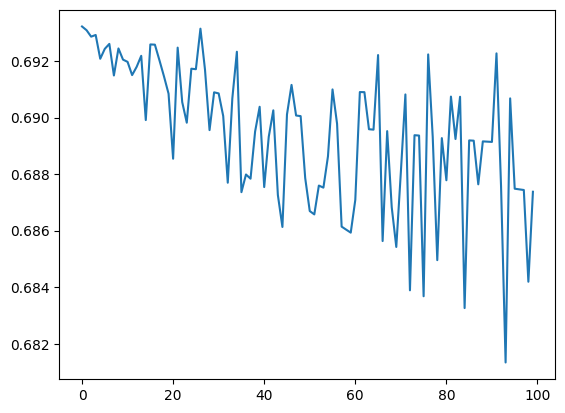

In [34]:
# Pérdida y precisión
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Pérdida y precisión en la misma gráfica
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()


Ya habiendo ampliado la información disponible para entrenar la red neuronal vamos a hacer una prueba de predicción real:

<h1>PRUEBA GOLES<h1>

In [ ]:
'''# Preprocesamiento de datos
X = combined_data[['Home Team', 'Away Team', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio']].values
y = combined_data[['Winner', 'Home Team Goals', 'Away Team Goals']].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio']

X_categorical = combined_data[categorical_features].values
X_numeric = combined_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y_winner = label_encoder.fit_transform(y[:, 0])
y_home_goals = y[:, 1]
y_away_goals = y[:, 2]

num_winner_classes = len(label_encoder.classes_)

# Convertir etiquetas a formato categórico solo para el resultado del ganador
y_winner = to_categorical(y_winner, num_classes=num_winner_classes)

print("Número de muestras en X:", X.shape[0])
print("Número de muestras en y_winner:", y_winner.shape[0])

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_winner_train, y_winner_test, y_home_goals_train, y_home_goals_test, y_away_goals_train, y_away_goals_test = train_test_split(X_combined, y_winner, y_home_goals, y_away_goals, test_size=0.2, random_state=42)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)

# Definir modelo de red neuronal con arquitectura modificada
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

# Modelo de salida para la predicción del ganador
model.add(Dense(num_winner_classes, activation='softmax', name='winner_output'))

# Compilar y entrenar el modelo...
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_winner_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo para predicción del ganador
loss, accuracy = model.evaluate(X_test, y_winner_test)
print("Test Loss (Winner):", loss)
print("Test Accuracy (Winner):", accuracy)

# Preparar el modelo para la predicción de los goles de los equipos
model_goals = Sequential()
model_goals.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_goals.add(Dropout(0.5))
model_goals.add(Dense(64, activation='relu'))
model_goals.add(Dropout(0.5))
model_goals.add(Dense(32, activation='relu'))

# Modelo de salida para la predicción de los goles del equipo local
model_goals.add(Dense(1, name='home_goals_output'))

# Compilar y entrenar el modelo...
model_goals.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_goals.fit(X_train, y_home_goals_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo para predicción de los goles del equipo local
loss, mae = model_goals.evaluate(X_test, y_home_goals_test)
print("Test Loss (Home Goals):", loss)
print("Test MAE (Home Goals):", mae)

# Modelo de salida para la predicción de los goles del equipo visitante
model_goals.add(Dense(1, name='away_goals_output'))

# Compilar y entrenar el modelo...
model_goals.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_goals.fit(X_train, y_away_goals_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo para predicción de los goles del equipo visitante
loss, mae = model_goals.evaluate(X_test, y_away_goals_test)
print("Test Loss (Away Goals):", loss)
print("Test MAE (Away Goals):", mae)
'''

Número de muestras en X: 744
Número de muestras en y_winner: 744


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0482 - loss: 4.1730 - val_accuracy: 0.0672 - val_loss: 4.1676
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0531 - loss: 4.1656 - val_accuracy: 0.0672 - val_loss: 4.1602
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0661 - loss: 4.1581 - val_accuracy: 0.0672 - val_loss: 4.1529
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0782 - loss: 4.1505 - val_accuracy: 0.0672 - val_loss: 4.1455
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0454 - loss: 4.1427 - val_accuracy: 0.0840 - val_loss: 4.1384
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0766 - loss: 4.1361 - val_accuracy: 0.0840 - val_loss: 4.1313
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0571 - loss: 4.1288 - val_accuracy: 0.0840 - val_loss: 4.1244
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0727 - loss: 4.1193 - val_accuracy: 0.0840 - 

Hemos rellenado la red neuronal con mucha más información. Ahora vamos a ver que tal predice el resultado de los partidos basándonos en la información ya existente de los csv: